# Random Forest

En este tutorial trabajaremos con Random Forest y su uso en un problema de regresión.

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
#import multiprocessing

from scipy.stats import randint as sp_randint

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [ ]:
def rmse(y_test, y_test_pred):
  """ Este es mi cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

Utilizaremos el dataset de Housing de California

In [ ]:
housing = fetch_california_housing()

X = housing.data
y = housing.target

In [ ]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [ ]:
# Holdout para la evaluación del modelo. 33% de los datos disponibles para test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

In [ ]:
# Para dibujar las predicciones y los valores reales
def pintaResultados (reg, n):
  plt.subplots(figsize=(30, 5))
  x = np.arange(y_test[:n].size)
  pred = reg.predict(X=X_test)
  plt.plot(x, y_test[:n], 'b.', label='Verdaderas')
  plt.plot(x, pred[:n], 'g^', label='Predichas')
  plt.legend();

Los parámetros más importantes de RF son:
- `n_estimators`; número de árboles incluidos en el modelo.
- `max_depth`: profundidad máxima que pueden alcanzar los árboles.
- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(`min_samples_split` * `n_samples`).
- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(`min_samples_split` * `n_samples`).
- `max_features`: número de predictores considerados a en cada división. Puede ser:
  - Un valor entero
  - Una fracción del total de predictores. Se calcula como `max(1, int(max_features * n_features_in_))`. Si su valor es `1.0` tiene en cuenta todos los predictores
  - `“sqrt”`, raiz cuadrada del número total de predictores.
  - `“log2”`, log2 del número total de predictores.
  - `None`, utiliza todos los predictores (igual que `1.0`)
- `oob_score`: Si se calcula o no el out-of-bag R^2. Por defecto es `False` ya que aumenta el tiempo de entrenamiento.

RMSE de RF: 0.5320343094998106


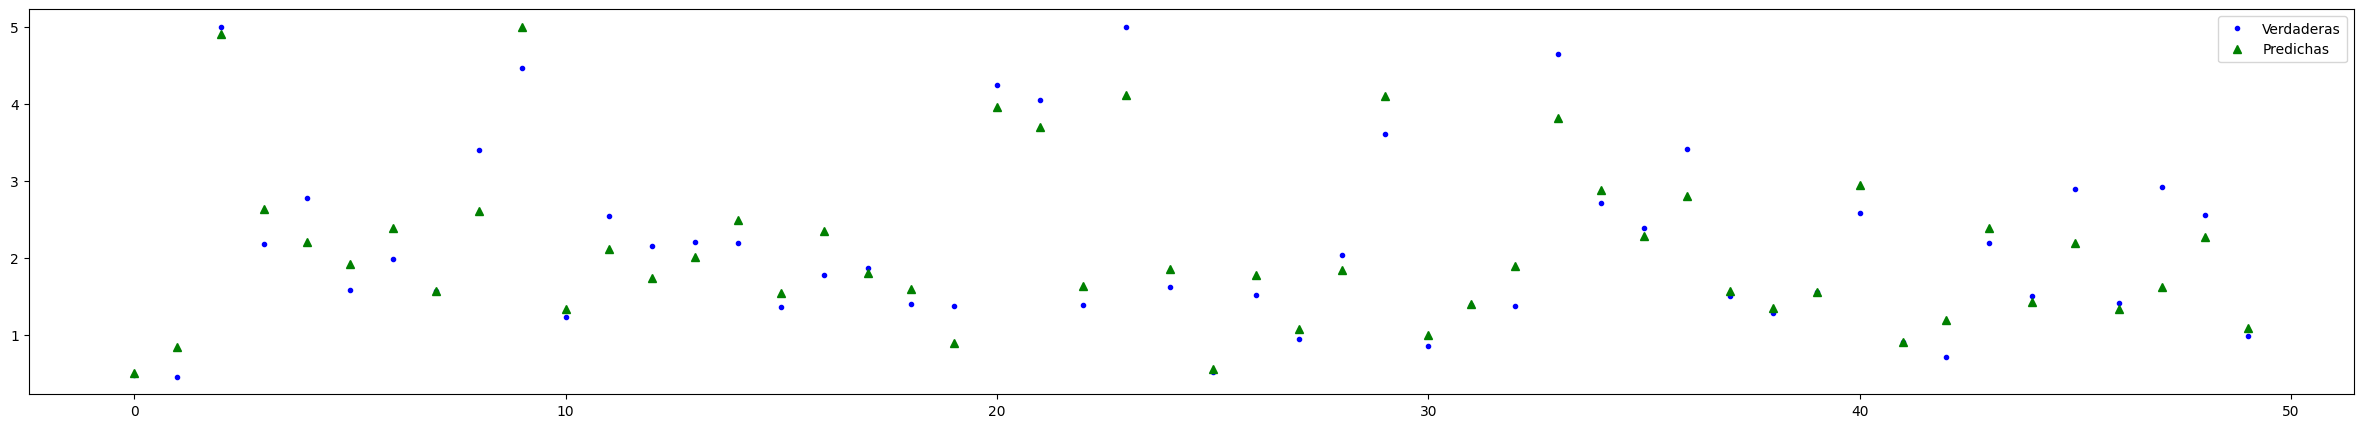

In [ ]:
# Creación del modelo
# ==============================================================================
regr_rf = RandomForestRegressor(
            n_estimators = 10,
            max_depth    = None,
            max_features = 1.0,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 42
         )

# Entrenamiento del modelo
# ==============================================================================
regr_rf.fit(X_train, y_train)
print(f"RMSE de RF: {rmse(y_test, regr_rf.predict(X=X_test))}")
pintaResultados(regr_rf,50)

## Optimización de parámetros
### Número de árboles `n_estimators`
Este no es un parámetro crítico. Podemos ir creciendo el número de árboles ya que no supone ningún problema de overfitting. Sin embargo, llegado a un valor, no se van a obtener mejores resultados. Por lo tanto, conviene coger el número de árboles justo.

En los modelos RF se cuenta con el valor de Out_of_Bag, que refleja las instancias que no han sido utilizadas en el entrenamiento de un determinado árbol. Las podemos usar para calcular la eficiencia de los modelos sin tener que recurrir a la validación cruzada. El valor de `oob_score` es R^2.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Valor óptimo de n_estimators: 141


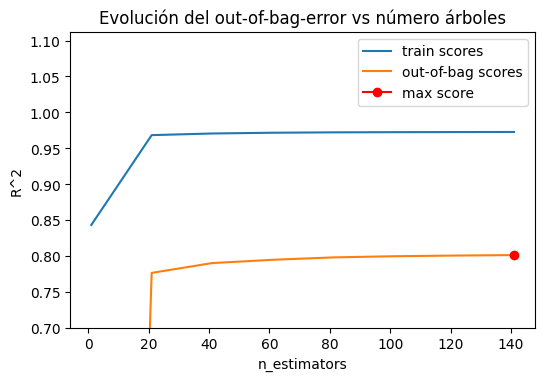

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 20)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                max_depth    = None,
                max_features = 1.0,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
ax.set_ylim([0.7,None])
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Podemos comprobar que si ampliamos el valor de `n_estimators` el valor de R^2 crece, pero con unos aumentos muy pequeños. Por la gráfica, nos podemos quedar con un valor de 40

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

Valor óptimo de n_estimators: 141


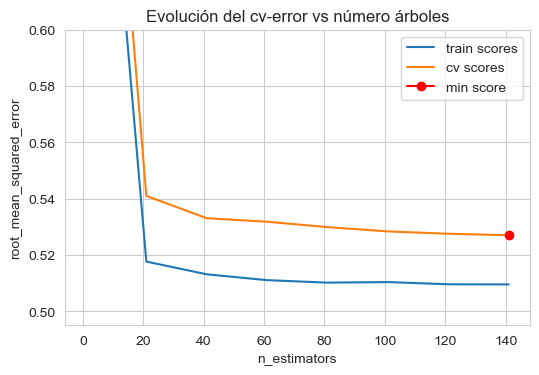

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 20)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                max_depth    = None,
                max_features = 1.0,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 42
             )

    # Error de train
    modelo.fit(X_train, y_train)
    train_scores.append(rmse(y_test, modelo.predict(X=X_test)))

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 3
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
ax.set_ylim([None,0.6])
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Igualmente, se comprueba que con 40 árboles el error se estabiliza. Por lo que tomamos un valor de `n_estimators` de 40

### Máximo número de atributos
El valor de `max_features` es uno de los hiperparámetros más importantes de RF, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.


Valor óptimo de max_features: 3


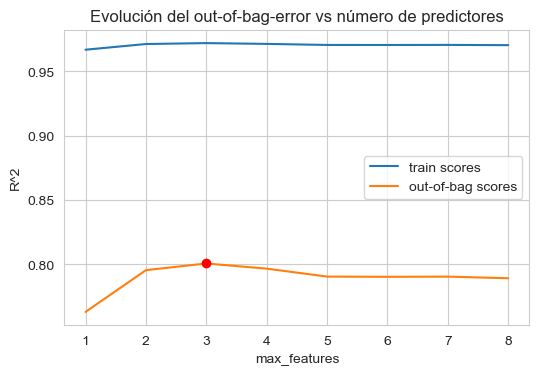

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 40,
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Valor óptimo de max_features: 3


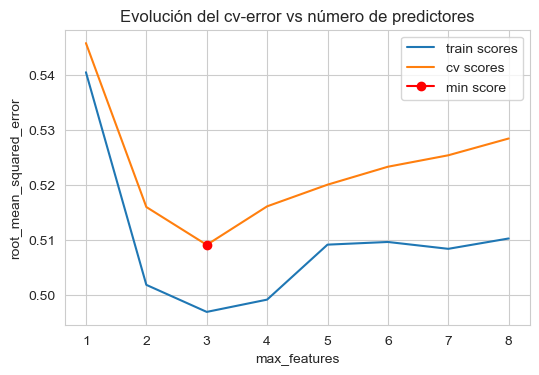

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:

    modelo = RandomForestRegressor(
                n_estimators = 100,
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 42
             )

    # Error de train
    modelo.fit(X_train, y_train)
    train_scores.append(rmse(y_test, modelo.predict(X=X_test)))

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 3
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Analizando los dos resultados, entendemos que el mejor parámetro para `max_features` está para un valor de 3.

## Búsqueda de parámetros con Random Search
La búsqueda de parámetros no la podemos hacer de forma secuencial porque unos parámetros pueden influir en otros. Vamos a realizar una búsqueda usando Random Search

In [ ]:
# Quitar comentario si se quiere evaluar el modelo
# outer = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {'n_estimators': sp_randint(10,200),
              'max_features': sp_randint(1,X.shape[1])}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
regr = RandomizedSearchCV(RandomForestRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         cv=inner,
                         refit=True,
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )

np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# Quitar comentario si se quiere evaluar el modelo
"""
scores = -cross_val_score(regr,
                            X, y,
                            scoring='neg_mean_squared_error',
                            cv = outer)
"""

Fitting 3 folds for each of 20 candidates, totalling 60 fits


"\nscores = -cross_val_score(regr, \n                            X, y, \n                            scoring='neg_mean_squared_error', \n                            cv = outer)\n"

RMSE de RF con búsqueda de hiperparámetros: 0.49985628295566353


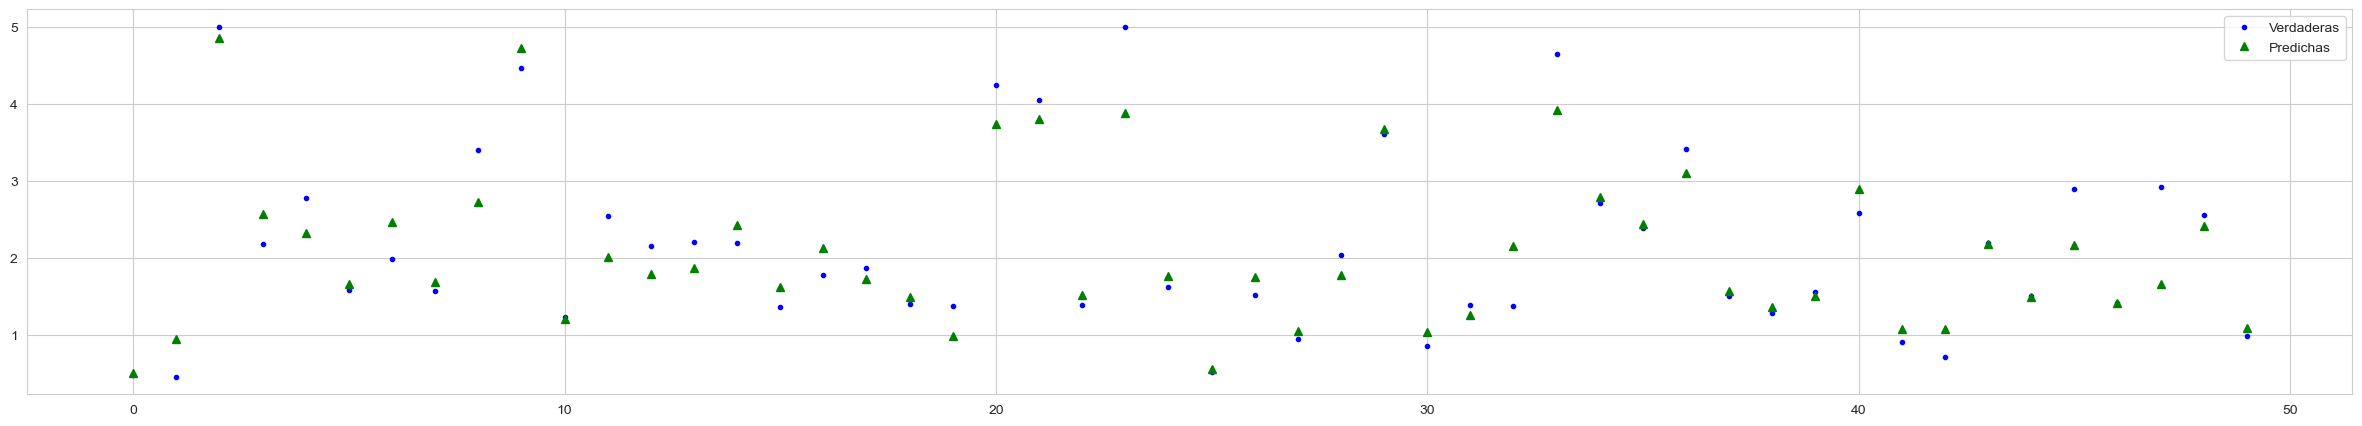

In [ ]:
print(f"RMSE de RF con búsqueda de hiperparámetros: {rmse(y_test, regr.predict(X=X_test))}")
pintaResultados(regr,50)

In [ ]:
regr.best_params_, -regr.best_score_

({'max_features': 3, 'n_estimators': 97}, 0.2601429441590271)

Los mejores parámetros son un número de árboles de 97 y un número máximo de características de 3.

In [ ]:
# Descomentar si vamos a estimar el error de mi modelo
"""
print(scores)
# Nos devuelve MSE, calculo RMSE
scores = np.sqrt(scores)
# La media de los 5-fold con cross validation. Es la estimación del error de mi modelo.
print(f"{scores.mean()} +- {scores.std()}")
"""

'\nprint(scores)\n# Nos devuelve MSE, calculo RMSE\nscores = np.sqrt(scores)\n# La media de los 5-fold con cross validation. Es la estimación del error de mi modelo. \nprint(f"{scores.mean()} +- {scores.std()}")\n'

Al poner el parámetro `refit=True` se reentrena el modelo indicando los valores óptimos en sus argumentos. Este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.

In [ ]:
modelo_final = regr.best_estimator_
# Entrenamos con todos los datos para el modelo final
_ = modelo_final.fit(X,y)

## Importancia por pureza
Calculamos la importancia por la pureza de los nodos. Cuantifica el incremento total en la pureza de los nodos debido a divisiones en las que participa el predictor (promedio de todos los árboles).

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': housing.feature_names,
                             'importancia': modelo_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,MedInc,0.394912
6,Latitude,0.129558
5,AveOccup,0.128371
7,Longitude,0.120976
2,AveRooms,0.102104
1,HouseAge,0.054647
3,AveBedrms,0.038176
4,Population,0.031257


## Importancia por permutación
Identifica la influencia que tiene cada predictor sobre una determinada métrica de evaluación del modelo

In [ ]:
from sklearn.inspection import permutation_importance
import multiprocessing

importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 42
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
# df_importancia['feature'] = X_train.columns
df_importancia['feature'] = housing.feature_names
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,0.793562,0.003868,MedInc
6,0.614049,0.003303,Latitude
7,0.546722,0.002820,Longitude
5,0.438066,0.004394,AveOccup
2,0.237332,0.001420,AveRooms
1,0.222865,0.003400,HouseAge
3,0.104616,0.001007,AveBedrms
4,0.089603,0.001095,Population


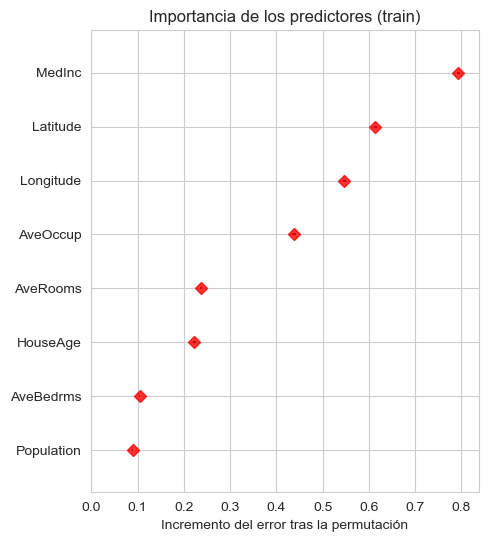

In [ ]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

# EXTRA (EXTREMLY RANDOMIZED) TREES
Son otro tipo de ensemble por bagging muy parecidos a los Random Forest. Se diferencian en:

1.   No aplican bootstraping y utilizan todas las muestras disponibles
2.   A la hora de elegir el nodo de partición utilizan un valor aleatorio para los atributos disponibles, quedándose con el mejor. Esto hace que sean más rápidos.

Hay dos parámetros de interés, pero nosotros no los vamos a usar en la búsqueda de hiperparámetros:
- `criterion` ={“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error” Mide la calidad de la partición realizada.
- `bootstrapbool`, default=False. Si se utiliza bootstraping en la selección de muestras. Con el valor de `False`, se utilizan todas las muestras.




In [ ]:
# Quitar comentario si se quiere evaluar el modelo
# outer = KFold(n_splits=3, shuffle=True, random_state=42)

# espacio de búsqueda
param_grid = {'n_estimators': sp_randint(10,200),
              'max_features': sp_randint(1,X.shape[1])}

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 20
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
regr = RandomizedSearchCV(ExtraTreesRegressor(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         refit=True,
                         cv=inner,
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )
np.random.seed(42)
regr.fit(X=X_train, y=y_train)

# Quitar comentario si se quiere evaluar el modelo
"""
scores = -cross_val_score(regr,
                            X, y,
                            scoring='neg_mean_squared_error',
                            cv = outer)
"""

Fitting 3 folds for each of 20 candidates, totalling 60 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


"\nscores = -cross_val_score(regr, \n                            X, y, \n                            scoring='neg_mean_squared_error', \n                            cv = outer)\n"

RMSE de RF con búsqueda de hiperparámetros: 0.49040524704526184


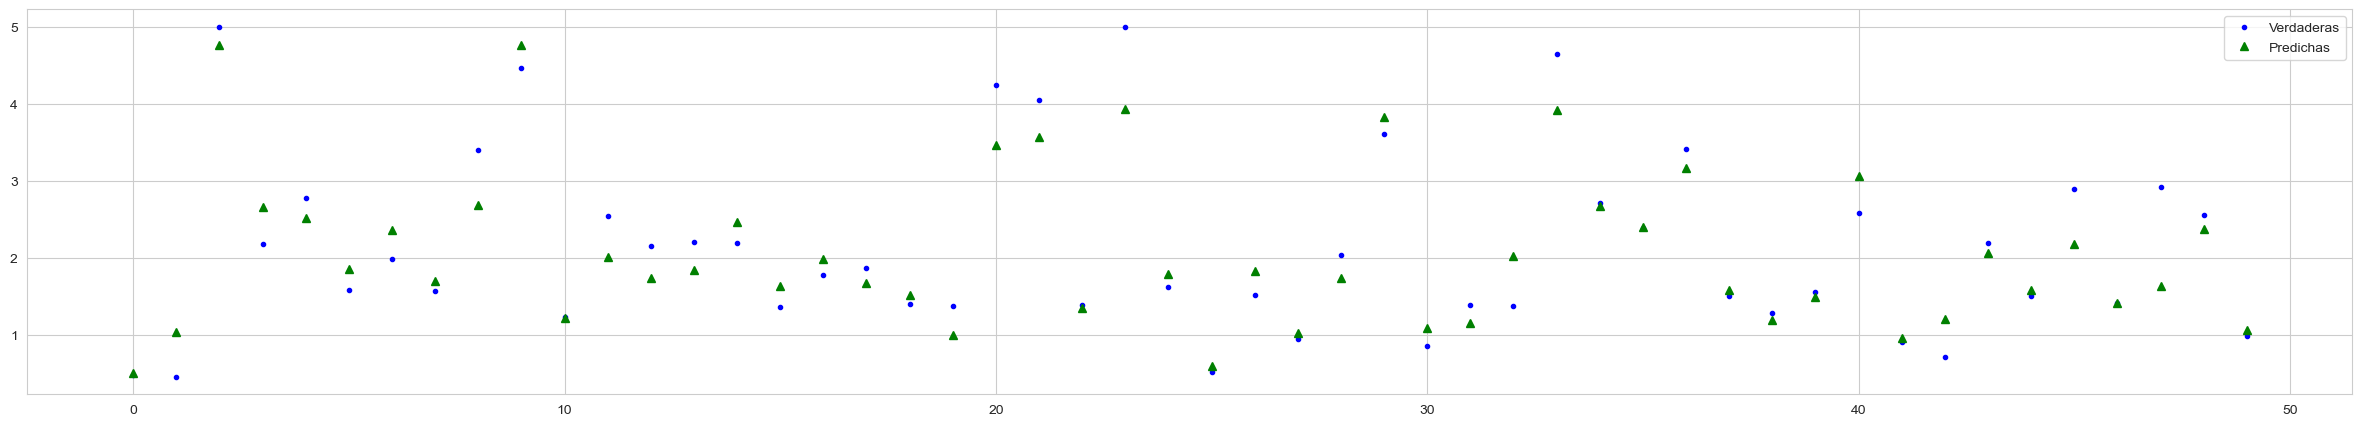

In [ ]:
print(f"RMSE de RF con búsqueda de hiperparámetros: {rmse(y_test, regr.predict(X=X_test))}")
pintaResultados(regr,50)

In [ ]:
regr.best_params_, -regr.best_score_

({'max_features': 3, 'n_estimators': 159}, 0.24809958501123938)

Al poner el parámetro `refit=True` se reentrena el modelo indicando los valores óptimos en sus argumentos. Este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.

In [ ]:
modelo_final_Extra = regr.best_estimator_
# Entrenamos con todos los datos para el modelo final
_ = modelo_final_Extra.fit(X,y)

# Selección de características (opcional, no necesario para la práctica)


Vamos a conocer una forma de reducir el número de características de entrada de nuestros modelos. En sklearn existe una función `SelectKBest`. Junto con esta función se define otra función (en este caso `f_regression`, ya que estamos ante un problema de regresión). Además, se introduce un parámetro K para indicar que sólo queremos quedarnos con las K variables de entrada para hacer la regresión. `SelectKBest` evalúa el efecto individual de cada una de las variables de entrada y las ordena en función del error que comete.

El seleccionar un conjunto de variables, nos permitirá contar con problemas más pequeños (con menos variables de entrada).

In [ ]:
scaler = StandardScaler()
selector = SelectKBest(f_regression)
extratrees = ExtraTreesRegressor(max_features=4, n_estimators = 167 )

pipe_select_scale_extratrees = Pipeline([
    ('scale', scaler),
    ('select', selector),
    ('extratrees', extratrees)])

# Vamos a comprobar que valor de K sería el mejor
param_grid = {'select__k': list(range(1,9))}
inner = KFold(n_splits=3, shuffle=True, random_state = 42 )
# Como es pequeño podemos usar GridSearch
tune_select_scale_extratrees = GridSearchCV(pipe_select_scale_extratrees,
                                     param_grid,
                                     scoring="neg_mean_squared_error",
                                     cv=inner
                                     )

El modelo es entrenado

In [ ]:
np.random.seed(42)
tune_select_scale_extratrees.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7f7f51f529d0>)),
                                       ('extratrees',
                                        ExtraTreesRegressor(max_features=4,
                                                            n_estimators=167))]),
             param_grid={'select__k': [1, 2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [ ]:
# Comprobamos el valor de K seleccionado
tune_select_scale_extratrees.best_params_, np.sqrt(-tune_select_scale_extratrees.best_score_)

({'select__k': 8}, 0.500754278411329)

In [ ]:
trained_pipeline = tune_select_scale_extratrees.best_estimator_

print(f"Features selected: {trained_pipeline.named_steps['select'].get_support()}")

print(f"Locations where features selected: {np.where(trained_pipeline.named_steps['select'].get_support())}")


Features selected: [ True  True  True  True  True  True  True  True]
Locations where features selected: (array([0, 1, 2, 3, 4, 5, 6, 7]),)


In [ ]:
# También podemos comprobar el rendimiento para cada número de funciones
from pprint import pprint

pprint(list(zip(tune_select_scale_extratrees.cv_results_['param_select__k'].data, -tune_select_scale_extratrees.cv_results_['mean_test_score'])))

[(1, 1.0626728554409233),
 (2, 0.7457177395997604),
 (3, 0.5685003198592075),
 (4, 0.5200626566693685),
 (5, 0.4140749578038916),
 (6, 0.2913580539414151),
 (7, 0.27595535916448877),
 (8, 0.25075484734725084)]


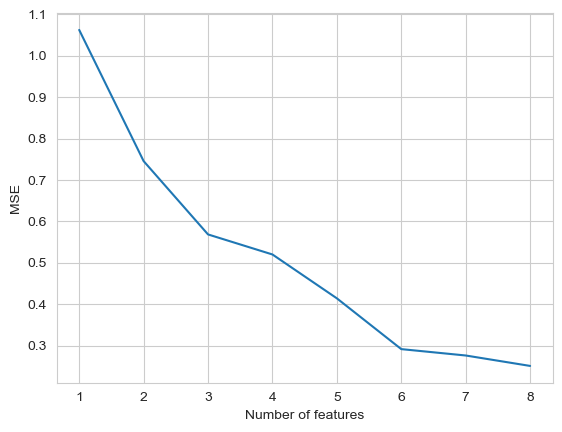

In [ ]:
# Pintamos el error en función de los valores de K
import matplotlib.pyplot as plt
plt.plot(tune_select_scale_extratrees.cv_results_['param_select__k'].data, -tune_select_scale_extratrees.cv_results_['mean_test_score'])
plt.ylabel('MSE')
plt.xlabel('Number of features')
plt.show()

Pero el resultado importante es la evaluación del modelo con las muestras de test

RMSE de Extra con selección de características: 0.49220412066652486


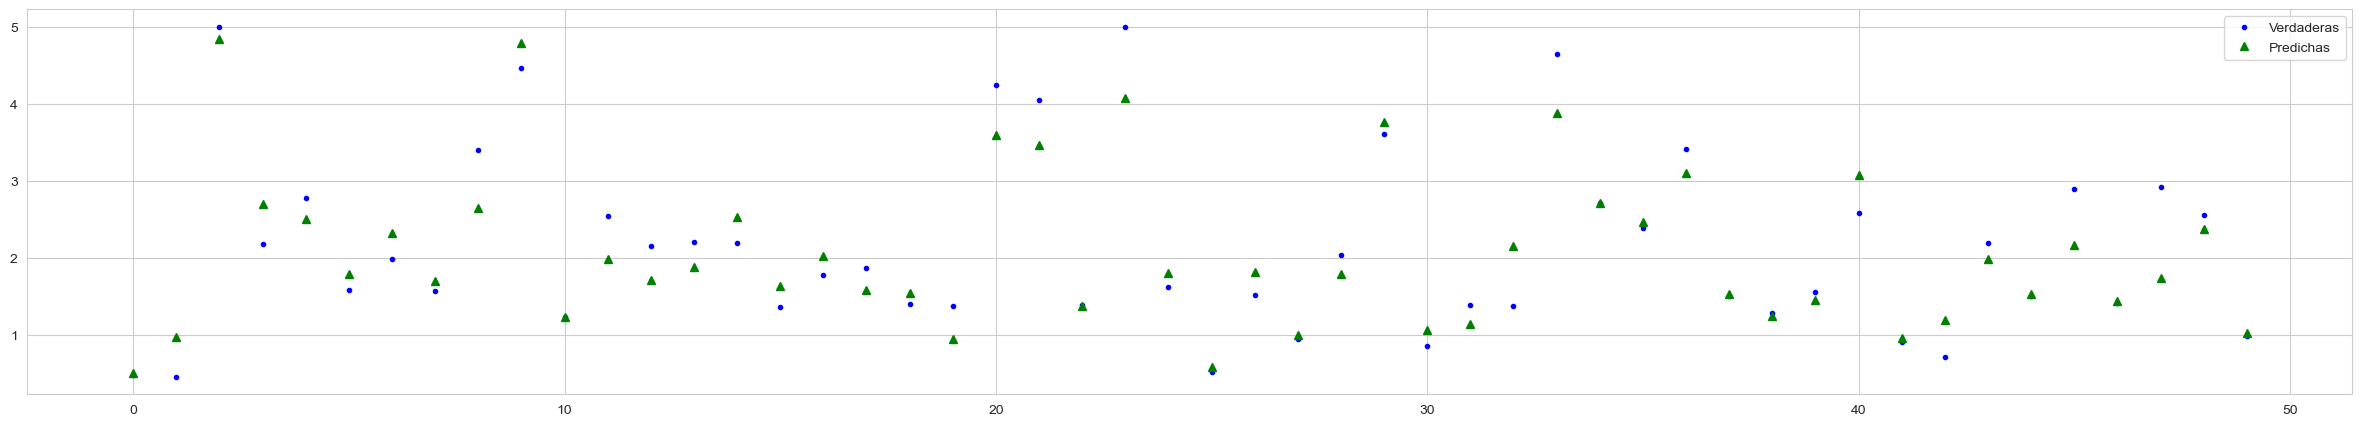

In [ ]:
# from sklearn.metrics import mean_squared_error
print(f"RMSE de Extra con selección de características: {rmse(y_test, trained_pipeline.predict(X=X_test))}")
pintaResultados(trained_pipeline,50)


Para nuestro caso, no hemos podido reducir el número de variables de entrada.